# BORROWER'S CREDIT RISK MODEL

In this project, my aim is to create a borrower's credit risk model for lenders. The Lending Club releases all data which contains approved or declined loan applications. You can download the data sets from this [website](https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F). Let's start with exploring and cleaning data.

### Opening and Clearing Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

I imported the Pandas and the Numpy libraries especially to use on my exploring and cleaning process. I will use the Sklearn library on my prediction process. 

In [2]:
loans_2007= pd.read_csv("loans_2007.csv")
loans_2007.drop_duplicates()
loans_2007.iloc[0]


C:\Users\shyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id                                1077501
member_id                      1.2966e+06
loan_amnt                            5000
funded_amnt                          5000
funded_amnt_inv                      4975
term                            36 months
int_rate                           10.65%
installment                        162.87
grade                                   B
sub_grade                              B2
emp_title                             NaN
emp_length                      10+ years
home_ownership                       RENT
annual_inc                          24000
verification_status              Verified
issue_d                          Dec-2011
loan_status                    Fully Paid
pymnt_plan                              n
purpose                       credit_card
title                            Computer
zip_code                            860xx
addr_state                             AZ
dti                                 27.65
delinq_2yrs                       

In [3]:
print(loans_2007.shape[1])

52


In [4]:
loans_2007.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          42538 non-null  object 
 1   member_id                   42535 non-null  float64
 2   loan_amnt                   42535 non-null  float64
 3   funded_amnt                 42535 non-null  float64
 4   funded_amnt_inv             42535 non-null  float64
 5   term                        42535 non-null  object 
 6   int_rate                    42535 non-null  object 
 7   installment                 42535 non-null  float64
 8   grade                       42535 non-null  object 
 9   sub_grade                   42535 non-null  object 
 10  emp_title                   39909 non-null  object 
 11  emp_length                  41423 non-null  object 
 12  home_ownership              42535 non-null  object 
 13  annual_inc                  425

There are a lot of columns in the data set and some of them are seen as useless. I have to decide which column is useful for my prediction model. 

In [5]:
# We will drop some colmns which is in cols list.
cols= ["id",
"member_id",
"funded_amnt",
"funded_amnt_inv",
"grade",
"sub_grade",
"emp_title",
"issue_d",
"zip_code",
"out_prncp",
"out_prncp_inv",
"total_pymnt",
"total_pymnt_inv",
"total_rec_prncp",
"total_rec_int",
"total_rec_late_fee",
"recoveries",
"collection_recovery_fee",
"last_pymnt_d",
"last_pymnt_amnt"]

I don't need the "id" and "member_id" columns. The "grade" and the "sub_grade" columns have the same information with the "int_rate" column. The "emp_title" column can be useful with additional data, but I don't have this data and it is useless for me. Only 3 of the 5 digits are visible in the "zip_code" column, so it is redundant. You can see the list of columns below which leak data from the future:
<br>
-"funded_amnt",
<br>
-"funded_amnt_inv",
<br>
-"issue_d",
<br>
-"out_prncp",
<br>
-"out_prncp_inv",
<br>
-"total_pymnt",
<br>
-"total_pymnt_inv",
<br>
-"total_rec_prncp",
<br>
-"total_rec_int",
<br>
-"total_rec_late_fee",
<br>
-"recoveries",
<br>
-"collection_recovery_fee",
<br>
-"last_pymnt_d",
<br>
-"last_pymnt_amnt".

All of these columns have information about loans after the loans already started to be paid off. Let's drop these columns.

In [6]:
loans_2007= loans_2007.drop(cols,axis=1)

In [7]:
loans_2007.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42535 non-null  float64
 1   term                        42535 non-null  object 
 2   int_rate                    42535 non-null  object 
 3   installment                 42535 non-null  float64
 4   emp_length                  41423 non-null  object 
 5   home_ownership              42535 non-null  object 
 6   annual_inc                  42531 non-null  float64
 7   verification_status         42535 non-null  object 
 8   loan_status                 42535 non-null  object 
 9   pymnt_plan                  42535 non-null  object 
 10  purpose                     42535 non-null  object 
 11  title                       42522 non-null  object 
 12  addr_state                  42535 non-null  object 
 13  dti                         425

Now, I have 32 columns to use. The 'loan_status' column shows that loan is accepted or dismissed. This column has text type values. Let's change the column type from text to numerical. 

In [8]:
loans_2007["loan_status"].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

I will only use entries which have 'Charged Off' and 'Fully Paid' values. This is because my aim is to make predictions about loans which are paid or not paid. Other values do not give proper information for my model. I will start with dropping the entries which have values out of our need.

In [9]:
loans_2007= loans_2007[(loans_2007["loan_status"]== "Fully Paid")|(loans_2007["loan_status"]== "Charged Off")]

In [10]:
loans_2007.shape

(38770, 32)

I will use a binary system.

In [11]:
status_replace= {"loan_status": {"Fully Paid": 1,"Charged Off": 0,}}
loans_2007= loans_2007.replace(status_replace)


In [12]:
loans_2007.loan_status.value_counts()

1    33136
0     5634
Name: loan_status, dtype: int64

After that, I will drop the columns which have only one unique value. These columns are not able to give information for the prediction model.

In [13]:
orig_columns= loans_2007.columns
drop_columns=[]
for col in orig_columns:
    col_series= loans_2007[col].dropna().unique()
    if len(col_series)== 1:
        drop_columns.append(col)
        
loans_2007= loans_2007.drop(drop_columns, axis=1)
print(drop_columns)

['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


### Preparing Features 

In this step, I will prepare the features for my prediction models. My focus is on the "Fully Paid" and the "Charged Off" entries on the "loan_status" column. As you remember, my value is 1 for the "Fully Paid" entry and 0 for the "Charged Off" entry. 

In [14]:
loans= loans_2007
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38770 entries, 0 to 39785
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38770 non-null  float64
 1   term                  38770 non-null  object 
 2   int_rate              38770 non-null  object 
 3   installment           38770 non-null  float64
 4   emp_length            37734 non-null  object 
 5   home_ownership        38770 non-null  object 
 6   annual_inc            38770 non-null  float64
 7   verification_status   38770 non-null  object 
 8   loan_status           38770 non-null  int64  
 9   purpose               38770 non-null  object 
 10  title                 38759 non-null  object 
 11  addr_state            38770 non-null  object 
 12  dti                   38770 non-null  float64
 13  delinq_2yrs           38770 non-null  float64
 14  earliest_cr_line      38770 non-null  object 
 15  inq_last_6mths     

Some columns have missing values, I have to get rid of these missing values. I will detect the missing values and develop a strategy to clean them.

In [15]:
loans.sample(2)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies
17227,4200.0,36 months,10.74%,136.99,4 years,RENT,43200.0,Source Verified,1,debt_consolidation,...,0.0,Mar-2007,0.0,4.0,0.0,1713.0,55.3%,6.0,Jul-2014,0.0
21652,7000.0,36 months,5.79%,212.29,10+ years,MORTGAGE,52500.0,Source Verified,1,car,...,0.0,Nov-1995,1.0,10.0,0.0,6619.0,35.1%,29.0,Oct-2014,0.0


In [16]:
null_counts= loans.isnull().sum()
print(null_counts[null_counts>0])

emp_length              1036
title                     11
revol_util                50
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64


The "emp_length" column and the "pub_rec_bankruptcies" columns have high amounts of missing values. 

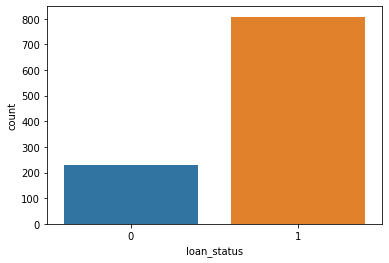

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.countplot(x="loan_status", data=loans[loans['emp_length'].isnull()])
plt.show()

Most of the missing values are in the "Fully Paid" entries. 

In [18]:
loans[loans['emp_length'].isnull()]['loan_status'].sum()

808

In [19]:
#The "pub_rec_bankruptcies" column will be dropped.
#Other rows which have missing values will be dropped.
loans= loans.drop("pub_rec_bankruptcies", axis=1)
loans= loans.dropna(axis=0)


I dropped the "pub_rec_bankruptcies" column because this column won't give me predictive values. After that, I only dropped the entries from: <br>-"emp_length",<br>-"title", <br>-"revol_util", <br>-"last_credit_pull_d"  columns. 
<br>I didn't drop these columns because I will use them on my prediction.

In [20]:
loans.loan_status.value_counts()

1    32286
0     5389
Name: loan_status, dtype: int64

In [21]:
print(loans.dtypes.value_counts())

object     11
float64    10
int64       1
dtype: int64


I need only numerical data types to use. I will explore the columns which are object data type. 

In [22]:
object_columns_df= loans.select_dtypes(include=["object"])
print(object_columns_df.iloc[0])

term                     36 months
int_rate                    10.65%
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
revol_util                   83.7%
last_credit_pull_d        Jun-2016
Name: 0, dtype: object


In [23]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']
for c in cols:
    print('Column', c)
    print(loans[c].value_counts())
    print('=================')

Column home_ownership
RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
Column verification_status
Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64
Column emp_length
10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64
Column term
 36 months    28234
 60 months     9441
Name: term, dtype: int64
Column addr_state
CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
LA     420
AL     420
KY     311
OK     285
UT     249
KS     249
AR     229
DC     209
RI     194
NM    

I counted the number of each value for the columns below:
<br>
['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state'] 
<br>
I will develop strategies to get rid of the missing values while using these counts.

In [24]:
print(loans["title"].value_counts())
print(loans["purpose"].value_counts())

Debt Consolidation         2068
Debt Consolidation Loan    1599
Personal Loan               624
Consolidation               488
debt consolidation          466
                           ... 
Ev                            1
Home Depot payoff             1
DaD                           1
Loan 12/2010                  1
payoff expenses               1
Name: title, Length: 18881, dtype: int64
debt_consolidation    17751
credit_card            4911
other                  3711
home_improvement       2808
major_purchase         2083
small_business         1719
car                    1459
wedding                 916
medical                 655
moving                  552
house                   356
vacation                348
educational             312
renewable_energy         94
Name: purpose, dtype: int64


In [25]:
#I will use mapping method to encode the 'emp_length' column.
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans= loans.replace(mapping_dict)

In [26]:
#I will drop some columns again.
loans= loans.drop(["last_credit_pull_d", "earliest_cr_line", "addr_state", "title"], axis=1)

I dropped the columns above because they have a lot of unique values, and they are not useful with these unique entries for my prediction.

In [27]:
#I will clean "%" character from two columns.
loans["int_rate"]= loans["int_rate"].str.rstrip("%").astype("float")
loans["revol_util"]= loans["revol_util"].str.rstrip("%").astype("float")

In [28]:
#I will encode the columns which are in the list below.
cat_columns=["home_ownership", "verification_status", "purpose", "term"]
dummy_df= pd.get_dummies(loans[cat_columns])
loans= pd.concat([loans, dummy_df], axis=1)
loans= loans.drop(cat_columns, axis=1)

In [29]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37675 entries, 0 to 39785
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            37675 non-null  float64
 1   int_rate                             37675 non-null  float64
 2   installment                          37675 non-null  float64
 3   emp_length                           37675 non-null  int64  
 4   annual_inc                           37675 non-null  float64
 5   loan_status                          37675 non-null  int64  
 6   dti                                  37675 non-null  float64
 7   delinq_2yrs                          37675 non-null  float64
 8   inq_last_6mths                       37675 non-null  float64
 9   open_acc                             37675 non-null  float64
 10  pub_rec                              37675 non-null  float64
 11  revol_bal                   

Now, I have 38 columns and 37675 entries to use. They are numerical values right now. I created my features and I can proceed to the prediction step.

### Prediction Step

I will use FPR and TPR metrics to observe my model's success. I want to get money. I do not want to give money to the wrong person. If I give money to the wrong person, we will lose money. So, my TPR value must be high and my FPR value must be low.

In [30]:
#I will start with making a basic prediction.
predictions = pd.Series(np.ones(loans.shape[0]))

In [31]:
#I will calculate TPR and FPR values for the first prediction.
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter=(predictions==0) & (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter=(predictions==0) & (loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+ tn)

print(tpr)
print(fpr)

1.0
1.0


In [32]:
confusion_matrix(predictions, loans["loan_status"])

array([[    0,     0],
       [ 5389, 32286]], dtype=int64)

In [33]:
predictions.value_counts()

1.0    37675
dtype: int64

I have found two of FPR and TPR values as 1. Because I predicted all of the values as 1, it shows that my prediction is correct for good results, but it is not true for bad results. After this step, I will use machine learning algorithm to improve my model. I will start first with logistic regression.

In [34]:
lr= LogisticRegression()

In [35]:
cols= loans.columns
train_cols= cols.drop("loan_status")
features= loans[train_cols]
target= loans["loan_status"]
lr.fit(features, target)
predictions= lr.predict(features)

C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


I have made a prediction with a logistic regression model. Let's test this prediction.

In [36]:
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter= (predictions== 0)& (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter= (predictions==0)&(loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+tn)
print(tpr)
print(fpr)

0.9987610729108592
0.9968454258675079


My TPR and FPR values are close to 1. I will make a cross validation prediction to improve it.


In [37]:
confusion_matrix(predictions, loans["loan_status"])

array([[   17,    40],
       [ 5372, 32246]], dtype=int64)

In [38]:
predictions= cross_val_predict(lr, features, target, cv=3)
predictions= pd.Series(predictions)

C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [39]:
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter= (predictions== 0)& (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter= (predictions==0)&(loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+tn)
print(tpr)
print(fpr)

0.99819743051914
0.9988153998025666


In [40]:
confusion_matrix(predictions, loans["loan_status"])

array([[   22,    42],
       [ 5367, 32244]], dtype=int64)

In [41]:
print(predictions.head(10), loans["loan_status"].head(10))

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
dtype: int64 0     1
1     0
2     1
3     1
5     1
6     1
7     1
8     0
9     0
10    1
Name: loan_status, dtype: int64


In [42]:
predictions.value_counts()

1    37611
0       64
dtype: int64

While you can see my model predicted almost every value as  1, let's perform cross validation process by setting class_weight parameter as balanced. 

In [43]:
lr =LogisticRegression(class_weight="balanced")
predictions = cross_val_predict(lr, features, target, cv=3)
predictions = pd.Series(predictions)

C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [44]:
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])


tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])


fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])


tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])


tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)

0.5465718405873099
0.5237907206317868


In [45]:
confusion_matrix(predictions, loans["loan_status"])

array([[ 3340, 13953],
       [ 2049, 18333]], dtype=int64)

I improved FPR value, and my TPR value decreased also. My FPR value is 52%, it has improved. Now, I can detect more unpaid payments. As you can see, I predicted 3326 true unpaid payments, but I lost 2063 unpaid payments. It means that my damage is too much. I have to drop my damage. I do not want this result, so I will change the balance of class_weight.

In [46]:
penalty = {
    0: 12,
    1: 1}
lr = LogisticRegression(class_weight=penalty, C=0.01)
predictions = cross_val_predict(lr, features, target, cv=15)
predictions = pd.Series(predictions)

C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [47]:
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter= (predictions== 0)& (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter= (predictions==0)&(loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+tn)
print(tpr)
print(fpr)

0.12126376507603566
0.12418558736426456


In [48]:
confusion_matrix(predictions, loans["loan_status"])

array([[ 5125, 27973],
       [  264,  4313]], dtype=int64)

In [49]:
penalty = {
    0: 15,
    1: 1.5}
lr = LogisticRegression(class_weight=penalty, C=0.01)
predictions = cross_val_predict(lr, features, target, cv=15)
predictions = pd.Series(predictions)

C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\shyl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [50]:
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter= (predictions== 0)& (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter= (predictions==0)&(loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+tn)
print(tpr)
print(fpr)

0.16445988463555322
0.16011846001974334


In [51]:
confusion_matrix(predictions, loans["loan_status"])

array([[ 4995, 26556],
       [  394,  5730]], dtype=int64)

I have dropped the FPR value, but my TPR is too small also. I predicted 5197 unpaid payments truly, and I couldn't predict only 192 unpaid payments. So, I can say that this model is more succesful. I will try another machine learning algorithm. With logistic regression I can only work with linear data; however, I can work on nonlinear data with random forests. 

In [52]:
rf=RandomForestClassifier(class_weight= "balanced", random_state=101)
predictions = cross_val_predict(rf, features, target, cv=10)
predictions = pd.Series(predictions)

In [53]:
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter= (predictions== 0)& (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter= (predictions==0)&(loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+tn)
print(tpr)
print(fpr)

0.9972469847928683
0.9972359328726554


In [54]:
print(confusion_matrix(predictions, loans["loan_status"]))

[[   43    62]
 [ 5346 32224]]


In [55]:
rf=RandomForestClassifier()
predictions = cross_val_predict(rf, features, target, cv=5)
predictions = pd.Series(predictions)

In [56]:
fp_filter= (predictions==1) & (loans["loan_status"]==0)
fp= len(predictions[fp_filter])
tp_filter= (predictions==1) & (loans["loan_status"]==1)
tp= len(predictions[tp_filter])
fn_filter= (predictions== 0)& (loans["loan_status"]==1)
fn= len(predictions[fn_filter])
tn_filter= (predictions==0)&(loans["loan_status"]==0)
tn= len(predictions[tn_filter])
tpr= tp/ (tp+fn)
fpr= fp/ (fp+tn)
print(tpr)
print(fpr)

0.9947561615102255
0.9948667324777888


In [57]:
print(confusion_matrix(predictions, loans["loan_status"]))

[[   76   123]
 [ 5313 32163]]


### Summary

In this project, my aim is to reduce FPR values and identify the best FPR value. After using different models and parametrics, my logistic regression model is more successful. I set the class_weight parameter as a penalty and set the C parameter as 0.01. I found the FPR value as 12%. It is the lowest rate I found. I predicted 5197 unpaid payments truly. The model is not fit to predict borrowers who are able to pay. However, it is useful to find delinquent borrowers with this performance.
<br>
Random forest classifier model is not seen to be fit to predict delinquent borrowers.